In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

import math
import pandas as pd
import numpy as np


# import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
df = pd.read_excel("forecast_data20242-025.xlsx", header=2)
df.head()

,TrnYear,TrnMonth,Register,Invoice,SummaryLine,DetailLine,InvoiceDate,Branch,Cust #,Customer Name,...,GlYear,GlPeriod,SalesOrder,ContractPrcNum,LineInvoiceDisc,PostCurrency,SalesOrderLine,StockUom,Colour,Container
0,2024,1,2,21165,1,1,2023-07-04,LD,L001,L001 - SA,...,2024,1,20044,202306-GENV1,0.0,R,1,EA,Magenta,Bottle 5L
1,2024,1,3,21166,1,1,2023-07-05,LD,E001,E001 - SA,...,2024,1,19998,202306-GENV1,0.0,R,1,EA,Cyan,Pouch 2000ml
2,2024,1,3,21166,1,2,2023-07-05,LD,E001,E001 - SA,...,2024,1,19998,202306-GENV1,0.0,R,2,EA,Magenta,Pouch 2000ml
3,2024,1,3,21166,1,3,2023-07-05,LD,E001,E001 - SA,...,2024,1,19998,202306-GENV1,0.0,R,3,EA,Yellow,Pouch 2000ml
4,2024,1,3,21166,1,4,2023-07-05,LD,E001,E001 - SA,...,2024,1,19998,202306-GENV1,0.0,R,4,EA,Clear,Bottle 2L


In [3]:

#easier column classification
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.rename( columns= {"InvoiceDate": "date" ,
                          "Customer Name": "cust_id",
                          "QtyInvoiced": "qty",
                          "Unit": "price",
                          "SKU": "item",
                          "Region2": "region",
                          "Colour": "color",
                          "Container": "container",
                          "NetSalesValue": "netsales",
                          "PostCurrency": "currency",
                         
                         })

#ensure ints and categories are category
df['item'] = df['item'].astype("category")
df['area'] = df['Area'].astype("category")
df['region'] = df['region'].astype("category")
df['area'] = df['Area'].astype("category")
df['cust_id'] = df['cust_id'].astype("category")
df["color_container"] = (df['color'] + "_" + df["container"]).astype("category")
df['color'] = df['color'].astype("category")
df['container'] = df['container'].astype("category")
df['currency'] = df['currency'].astype("category")
df["qty_sold"] = np.where(df["qty"] >= 0, df["qty"], 0)
df["qty_returned"] = np.abs(np.where(df["qty"] < 0, df["qty"], 0))
df["qty_sold_log"] = np.log1p(df["qty_sold"])
df = df.sort_values(by=["item", "date"])

In [4]:
df = df.drop(['TrnYear', 'TrnMonth', 'Register', 'Invoice', 'SummaryLine',
       'DetailLine',  'Branch', 'Cust #', 
     'SKU Description', 'Warehouse', 'Mass',
       'Volume',  'TaxValue', 'DiscValue', 'LineType',
       'PriceCode', 'DocumentType', 'GlYear', 'GlPeriod', 'SalesOrder',
       'ContractPrcNum', 'LineInvoiceDisc', 'SalesOrderLine',
       'StockUom'], axis=1)

In [5]:
df

,date,cust_id,Area,region,item,qty,price,netsales,currency,color,container,area,color_container,qty_sold,qty_returned,qty_sold_log
461,2023-07-21,P001 - SA,SA,SOUTH AFRICA,4750001,30,800,24000,R,Clear,Bottle 1L,SA,Clear_Bottle 1L,30,0,3.433987
877,2023-07-31,I001 - SA,SA,SOUTH AFRICA,4750001,-78,800,-62400,R,Clear,Bottle 1L,SA,Clear_Bottle 1L,0,78,0.000000
929,2023-08-07,P001 - SA,SA,SOUTH AFRICA,4750001,30,800,24000,R,Clear,Bottle 1L,SA,Clear_Bottle 1L,30,0,3.433987
936,2023-08-10,E002 - MA,MA,MAURITIUS,4750001,18,100,1800,USD,Clear,Bottle 1L,MA,Clear_Bottle 1L,18,0,2.944439
1479,2023-08-29,G002 - SA,SA,SOUTH AFRICA,4750001,30,800,24000,R,Clear,Bottle 1L,SA,Clear_Bottle 1L,30,0,3.433987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12550,2024-08-28,A001 - SA,SA,SOUTH AFRICA,4751177,30,800,24000,R,Black,Bottle 5kg,SA,Black_Bottle 5kg,30,0,3.433987
16574,2025-01-16,A001 - SA,SA,SOUTH AFRICA,4751177,28,800,22400,R,Black,Bottle 5kg,SA,Black_Bottle 5kg,28,0,3.367296
17222,2025-02-12,A001 - SA,SA,SOUTH AFRICA,4751177,-1,800,-800,R,Black,Bottle 5kg,SA,Black_Bottle 5kg,0,1,0.000000
18057,2025-03-06,A001 - SA,SA,SOUTH AFRICA,4751177,30,800,24000,R,Black,Bottle 5kg,SA,Black_Bottle 5kg,30,0,3.433987


In [6]:
target = "qty_sold_log"
sold_df = df[df["qty_returned"] == 0]
item_day = sold_df.groupby(['item', 'date'])[target].sum().reset_index()
# pivot = item_day.pivot(index='date', columns='item', values='qty_sold')
# print(pivot.head())

/tmp/ipykernel_13013/2673087010.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_day = sold_df.groupby(['item', 'date'])[target].sum().reset_index()


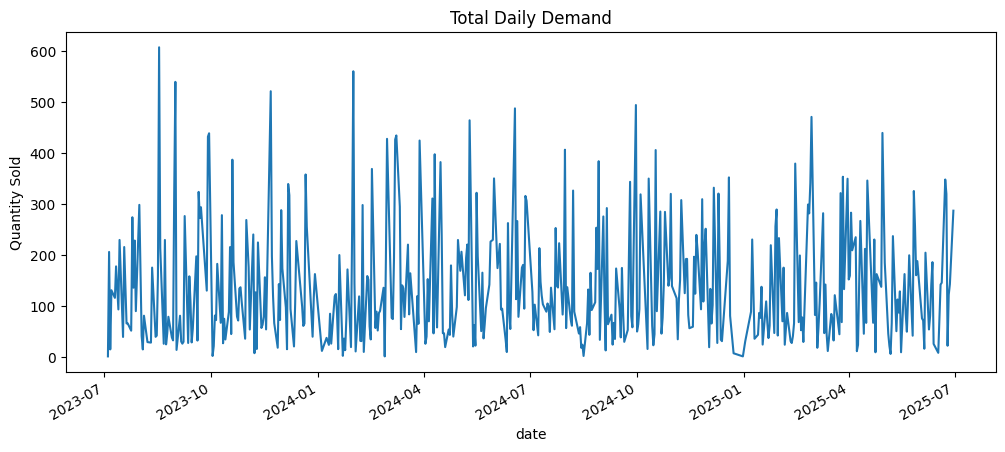

In [7]:
daily_total = item_day.groupby('date')[target].sum()
plt.figure(figsize=(12,5))
daily_total.plot(title='Total Daily Demand')
plt.ylabel('Quantity Sold')
plt.show()

In [8]:
# df = df_merged
item_day['dayofweek'] = item_day['date'].dt.dayofweek
item_day['dayofweek_sin'] = np.sin(2 * np.pi * item_day['dayofweek']/7)
item_day['dayofweek_cos'] = np.cos(2 * np.pi * item_day['dayofweek']/7)
item_day['month'] = item_day['date'].dt.month
item_day['month_sin'] = np.sin(2 * np.pi * item_day['month']/12)
item_day['month_cos'] = np.cos(2 * np.pi * item_day['month']/12)
item_day['dayofyear'] = item_day['date'].dt.dayofyear
item_day['dayofyear_sin'] = np.sin(2 * np.pi * item_day['dayofyear']/365)
item_day['dayofyear_cos'] = np.cos(2 * np.pi * item_day['dayofyear']/365)
item_day['day'] =  item_day['date'].dt.day
item_day['day_sin'] = np.sin(2 * np.pi * item_day['day']/30)
item_day['day_cos'] = np.cos(2 * np.pi * item_day['day']/30)
item_day['year'] = item_day['date'].dt.year
item_day['quarter'] = item_day.date.dt.quarter
item_day['quarter_sin'] = np.sin(2 * np.pi * item_day['quarter']/4)
item_day['quarter_cos'] = np.cos(2 * np.pi * item_day['quarter']/4)

In [9]:
item_day[(item_day["item"] == 4750198)]

,item,date,qty_sold_log,dayofweek,dayofweek_sin,dayofweek_cos,month,month_sin,month_cos,dayofyear,dayofyear_sin,dayofyear_cos,day,day_sin,day_cos,year,quarter,quarter_sin,quarter_cos
92393,4750198,2023-07-04,0.000000,1,0.781831,0.623490,7,-5.000000e-01,-0.866025,185,-0.043022,-0.999074,4,7.431448e-01,0.669131,2023,3,-1.000000e+00,-1.836970e-16
92394,4750198,2023-07-05,0.000000,2,0.974928,-0.222521,7,-5.000000e-01,-0.866025,186,-0.060213,-0.998186,5,8.660254e-01,0.500000,2023,3,-1.000000e+00,-1.836970e-16
92395,4750198,2023-07-06,0.000000,3,0.433884,-0.900969,7,-5.000000e-01,-0.866025,187,-0.077386,-0.997001,6,9.510565e-01,0.309017,2023,3,-1.000000e+00,-1.836970e-16
92396,4750198,2023-07-07,0.000000,4,-0.433884,-0.900969,7,-5.000000e-01,-0.866025,188,-0.094537,-0.995521,7,9.945219e-01,0.104528,2023,3,-1.000000e+00,-1.836970e-16
92397,4750198,2023-07-10,2.833213,0,0.000000,1.000000,7,-5.000000e-01,-0.866025,191,-0.145799,-0.989314,10,8.660254e-01,-0.500000,2023,3,-1.000000e+00,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92857,4750198,2025-06-24,0.000000,1,0.781831,0.623490,6,1.224647e-16,-1.000000,175,0.128748,-0.991677,24,-9.510565e-01,0.309017,2025,2,1.224647e-16,-1.000000e+00
92858,4750198,2025-06-25,0.000000,2,0.974928,-0.222521,6,1.224647e-16,-1.000000,176,0.111659,-0.993747,25,-8.660254e-01,0.500000,2025,2,1.224647e-16,-1.000000e+00
92859,4750198,2025-06-26,0.000000,3,0.433884,-0.900969,6,1.224647e-16,-1.000000,177,0.094537,-0.995521,26,-7.431448e-01,0.669131,2025,2,1.224647e-16,-1.000000e+00
92860,4750198,2025-06-27,3.891820,4,-0.433884,-0.900969,6,1.224647e-16,-1.000000,178,0.077386,-0.997001,27,-5.877853e-01,0.809017,2025,2,1.224647e-16,-1.000000e+00


In [93]:
item_day_group = item_day.groupby(["item"])
item_day['days_since_last_sale'] = (
    item_day_group['date']
    .diff().dt.days
)

item_day['days_since_last_sale'] = item_day['days_since_last_sale'].fillna(999)

item_day['rolling_q75_month'] = (
    item_day_group[target]
    .shift(1).rolling(20).quantile(0.75)
)
item_day['rolling_q90_month'] = (
    item_day_group[target]
    .shift(1).rolling(20).quantile(0.90)
)

/tmp/ipykernel_6452/2104304782.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_day_group = item_day.groupby(["item"])


In [69]:
item_day.columns

Index(['item', 'date', 'qty_sold_log', 'dayofweek', 'dayofweek_sin',
       'dayofweek_cos', 'month', 'month_sin', 'month_cos', 'dayofyear',
       'dayofyear_sin', 'dayofyear_cos', 'day', 'day_sin', 'day_cos', 'year',
       'quarter', 'days_since_last_sale', 'rolling_q75_30', 'rolling_q90_30'],
      dtype='object')

In [94]:
#create lags and rolling
lags = [1, 5, 10, 20]
for lag_i in lags:
    item_day[f"{target}_lag{lag_i}"] =  item_day_group[target].shift(lag_i)
lag_feats = [ f"{target}_lag{i}" for i in lags]


In [95]:
lag_feats

['qty_sold_log_lag1',
 'qty_sold_log_lag5',
 'qty_sold_log_lag10',
 'qty_sold_log_lag20']

In [96]:
#Example: 2-day rolling mean for each client-item pair
item_day_group = item_day.groupby(["item"])
for i in [1, 3, 5, 10, 20]:
    item_day[f"rolling_mean_{i}"] = (
        item_day_group[target]
            .shift(1)
            .rolling(i)
            .mean()
    )
    lag_feats.append(f"rolling_mean_{i}")
    item_day[f"rolling_std_{i}"] = (
        item_day_group[target]
            .shift(1)
            .rolling(i)
            .std()
    )

    item_day[f"rolling_nonzero_{i}"] = ( 
        item_day_group[target]
            .shift(1)
            .rolling(i)
            .apply(lambda x: (x>0).sum())
    )
    
    lag_feats.append(f"rolling_std_{i}")

/tmp/ipykernel_6452/567585316.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  item_day_group = item_day.groupby(["item"])


In [97]:
def split_train_test(df, split_date):
    train = df[df['date'] < split_date].copy()
    test = df[df['date'] >= split_date].copy()
    return (train, test)

def target_feature_split(df, features, target):
    X, y = df[features], df[target]
    return (X, y)
    

In [98]:
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np


def train_model(train, val, cat_feats, params):
    model = LGBMRegressor(
    **params
    )

    model.fit(
    train["X"], train["y"],
    eval_set=[(val["X"], val["y"])],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=[]
    )

    return model

def evaluate_model(model, X_val, y_val):
    val_pred = model.predict(X_val)
    # rmsle = root_mean_squared_log_error(y_val, val_pred)
    rmse = root_mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    # print(f"Validation RMSLE: {rmsle:.5f}")
    print(f"Validation RMSE: {rmse:.5f}")
    print(f"Validation MAE: {mae:.5f}")
    return val_pred

In [99]:
import matplotlib.pyplot as plt

# Example variables
# y_train: training target values
# y_val: validation target values
# y_pred: model predictions on validation set
def plot_target(y_val, y_pred, figsize = (12,6)):
    plt.figure(figsize= figsize)
    
    y_val = np.array(y_val)
    y_pred = np.array(y_pred)
    
    # Plot validation target
    plt.plot(np.arange(len(y_val)), y_val, label="y_val", color="green")
    
    # Plot predictions
    plt.plot(np.arange(len(y_pred)), y_pred, label="y_pred", color="red", linestyle="--")
    
    plt.xlabel("Time / Index")
    plt.ylabel("Quantity")
    plt.title("Validation vs Predictions")
    plt.legend()
    plt.show()

In [76]:
import numpy as np
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor


class HyperPSOTuning:

    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        
    def lgb_obj_function(self,params):
        losses = []
        for p in params:
            num_leaves = int(p[0])
            max_depth = int(p[1])
            learning_rate = p[2]
            n_estimators = int(p[3])
            feature_fraction = p[4]
            bagging_fraction = p[5]
            bagging_freq = int(p[6])
            lambda_l1 = p[7]
            lambda_l2 = p[8]
            min_data_in_leaf = int(p[9])
    
            model = LGBMRegressor(
                objective="regression",
                metric="rmse",
                boosting_type="gbdt",
                n_estimators=n_estimators,  
                num_leaves=num_leaves,
                max_depth=max_depth,
                learning_rate=learning_rate,
                feature_fraction=feature_fraction,
                bagging_fraction=bagging_fraction,
                bagging_freq=bagging_freq,
                lambda_l1=lambda_l1,
                lambda_l2=lambda_l2,
                min_data_in_leaf=min_data_in_leaf,
                verbose=-1
            )
            model.fit(self.X_train, self.y_train)
            preds = model.predict(self.X_val)
            rmse = root_mean_squared_error(self.y_val, preds)
            losses.append(rmse)
    
        return np.array(losses)

    def tune(self,lb, ub):
        options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

        optimizer = GlobalBestPSO(
            n_particles=10,   
            dimensions=len(lb),     
            options=options,
            bounds=(lb, ub)
        )


        best_cost, best_pos = optimizer.optimize(self.lgb_obj_function, iters=20)
        return best_cost, best_pos

In [40]:
basic_feats

NameError: name 'basic_feats' is not defined

In [100]:
item_day

,item,date,qty_sold_log,dayofweek,dayofweek_sin,dayofweek_cos,month,month_sin,month_cos,dayofyear,...,rolling_nonzero_3,rolling_mean_5,rolling_std_5,rolling_nonzero_5,rolling_mean_10,rolling_std_10,rolling_nonzero_10,rolling_mean_20,rolling_std_20,rolling_nonzero_20
0,4750001,2023-07-04,0.000000,1,0.781831,0.623490,7,-5.000000e-01,-0.866025,185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4750001,2023-07-05,0.000000,2,0.974928,-0.222521,7,-5.000000e-01,-0.866025,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4750001,2023-07-06,0.000000,3,0.433884,-0.900969,7,-5.000000e-01,-0.866025,187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4750001,2023-07-07,0.000000,4,-0.433884,-0.900969,7,-5.000000e-01,-0.866025,188,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4750001,2023-07-10,0.000000,0,0.000000,1.000000,7,-5.000000e-01,-0.866025,191,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552008,4751177,2025-06-24,3.806662,1,0.781831,0.623490,6,1.224647e-16,-1.000000,175,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
552009,4751177,2025-06-25,0.000000,2,0.974928,-0.222521,6,1.224647e-16,-1.000000,176,...,1.0,0.761332,1.702391,1.0,0.380666,1.203772,1.0,0.190333,0.851196,1.0
552010,4751177,2025-06-26,0.000000,3,0.433884,-0.900969,6,1.224647e-16,-1.000000,177,...,1.0,0.761332,1.702391,1.0,0.380666,1.203772,1.0,0.190333,0.851196,1.0
552011,4751177,2025-06-27,0.000000,4,-0.433884,-0.900969,6,1.224647e-16,-1.000000,178,...,1.0,0.761332,1.702391,1.0,0.380666,1.203772,1.0,0.190333,0.851196,1.0


In [42]:
feats

NameError: name 'features' is not defined

In [101]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score,roc_auc_score
import numpy as np

# Define split date
split_date = '2025-03-01'
train , test = split_train_test(item_day, split_date)

feats = [col for col in train.columns if col not in ['date', target, 'qty_sold_log', 'demand_occur']]
# train['demand_occured'] = (train[target] > 0).astype(int)
# test['demand_occured'] = (test[target] > 0).astype(int)
# train_reg = train[train[target] > 0].copy()
# test_reg = test[test[target] > 0].copy()


X_train, y_train = target_feature_split(train, feats, target)
X_val, y_val = target_feature_split(test, feats, target)

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feats)
lgb_test = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=cat_feats)
params = {
    'objective': 'poisson',
    # 'tweedie_varianve_power': 1.3,
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train','valid'],
    num_boost_round=1000,
)




y_val_pred = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation RMSE: {rmse:.5f}")
print(f"Validation MAE: {mae:.5f}")
print(f"Val R2: {r2_score(y_val, y_val_pred):.5f}")
y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse:.5f}")
print(f"Training MAE: {mae:.5f}")
print(f"Training R2: {r2_score(y_train, y_train_pred):.5f}")

Validation RMSE: 0.68597
Validation MAE: 0.22413
Val R2: 0.05933
Training RMSE: 0.65708
Training MAE: 0.19744
Training R2: 0.19030


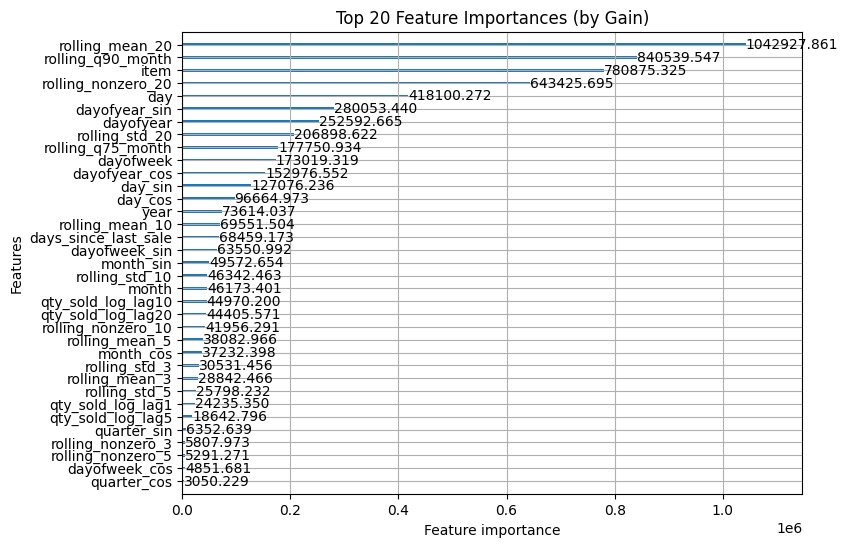

In [102]:
lgb.plot_importance(model, max_num_features=50, importance_type='gain', figsize=(8,6))
plt.title("Top 20 Feature Importances (by Gain)")
plt.show()

In [47]:
import lightgbm as lgb

lgb_train_reg = lgb.Dataset(X_train_reg, label=y_train_reg)

lgb_test_reg = lgb.Dataset(X_test_reg, label=y_test_reg, reference=lgb_train_reg)

train_param_reg = {
    "X": X_train_reg,
    "y": y_train_reg,
}

val_param_reg = {
    "X": X_val_reg,
    "y": y_val_reg,
}

cat_feats = []
model_reg = train_model(train_param_reg, val_param_reg, cat_feats, params)


# Evaluate (RMSLE)
pred_qty_cond = model_reg.predict(X_val_reg)
# rmsle = root_mean_squared_log_error(y_val, val_pred)
rmse = root_mean_squared_error(y_val_reg, pred_qty_cond)
mae = mean_absolute_error(y_val_reg, pred_qty_cond)
print(f"Validation RMSE: {rmse:.5f}")
print(f"Validation MAE: {mae:.5f}")
print(f"Val R2: {r2_score(y_val_reg, pred_qty_cond):.5f}")

NameError: name 'X_test_reg' is not defined

In [84]:
y_actual = y_val
y_pred = y_val_pred

In [85]:
resid_train = y_train - y_train_pred
resid_val = y_actual - y_pred

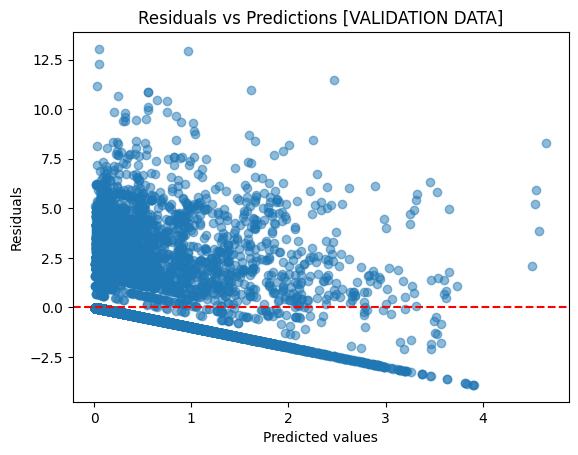

In [86]:
plt.scatter(y_pred, resid_val, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions [VALIDATION DATA]")
plt.show()

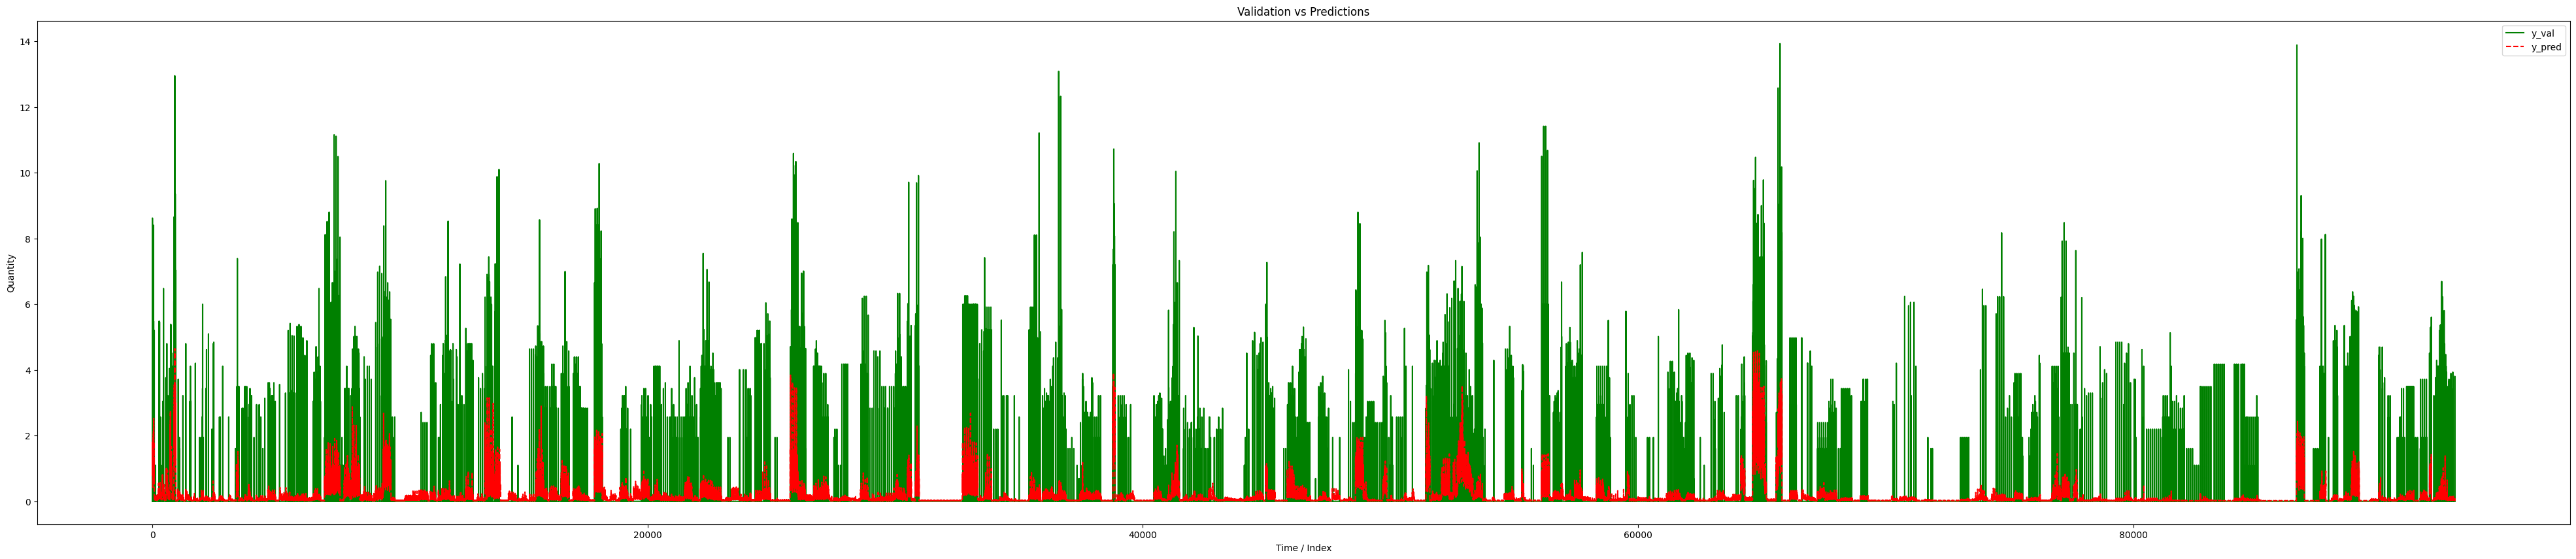

In [87]:
plot_target(y_val, y_val_pred, figsize=(50,10))

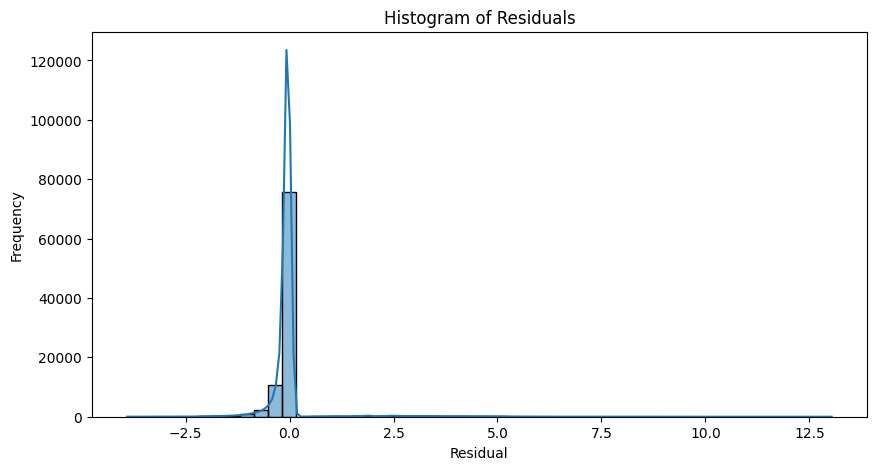

In [88]:
plt.figure(figsize=(10,5))
sns.histplot(resid_val, bins=50, kde=True, edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [100]:
test = test.copy()
test['pred_prob'] = pred_prob

# For Stage 2, create a full array where 0s get 0, and >0 get predicted quantity
pred_qty_full = np.zeros(len(test))
pred_qty_full[test[target]>0] = pred_qty_cond

# Expected demand
test['expected_demand'] = test['pred_prob'] * pred_qty_full

# Evaluate overall RMSE
overall_rmse = np.sqrt(mean_squared_error(test[target], test['expected_demand']))
print(f'Overall RMSE: {overall_rmse:.4f}')
print(f"R2: {r2_score(test[target], test['expected_demand']):.5f}")

Overall RMSE: 2970.0125
R2: -0.89585


In [70]:
# --- Lower and Upper Bounds (lb, ub) for PSO ---
# Each position in the array corresponds to a hyperparameter index.

lb = [
    16,     # [0] num_leaves — controls model complexity (fewer = simpler)
    2,      # [1] max_depth — tree depth (-1 means unlimited)
    0.001,  # [2] learning_rate — smaller = slower but more accurate training
    100,    # [3] n_estimators — number of boosting rounds (trees)
    0.3,    # [4] feature_fraction — fraction of features per iteration
    0.3,    # [5] bagging_fraction — fraction of data per iteration
    1,      # [6] bagging_freq — how often to perform bagging
    0.0,    # [7] lambda_l1 — L1 regularization term
    0.0,    # [8] lambda_l2 — L2 regularization term
    5,      # [9] min_data_in_leaf — min samples per leaf (controls overfitting)
    50,     # [10] max_bin — number of bins for discretizing continuous features
    0.0     # [11] min_gain_to_split — min gain required to make a split
]

ub = [
    512,    # [0] num_leaves — higher = more complex model, risk of overfitting
    16,     # [1] max_depth — deeper trees = more complex model
    0.3,    # [2] learning_rate — higher = faster training, more risk of overfit
    2000,   # [3] n_estimators — more boosting rounds for low learning rates
    1.0,    # [4] feature_fraction — use all features if 1.0
    1.0,    # [5] bagging_fraction — use full dataset if 1.0
    10,     # [6] bagging_freq — bagging every N iterations
    1.0,    # [7] lambda_l1 — stronger L1 = more feature sparsity
    5.0,    # [8] lambda_l2 — stronger L2 = smoother weights
    500,    # [9] min_data_in_leaf — larger = smoother model (less overfit)
    255,    # [10] max_bin — finer binning for continuous features
    5.0     # [11] min_gain_to_split — higher = only large gains allowed
]


tuner = HyperPSOTuning(X_train, y_train, X_val, y_val)
best_cost, best_pos = tuner.tune(lb, ub)

print("Best RMSE:", best_cost)
print("Best hyperparameters:", best_pos)

2025-09-28 17:53:23,585 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█|20/20, best_cost=20.
2025-09-28 18:09:26,447 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 20.252605046253695, best pos: [3.92358535e+02 1.21704439e+01 6.41706500e-03 2.12217018e+02
 6.73744934e-01 4.06576653e-01 6.30616637e+00 7.69415487e-01
 3.12892513e+00 3.38049030e+02 2.03398012e+02 2.46254949e+00]


Best RMSE: 20.252605046253695
Best hyperparameters: [3.92358535e+02 1.21704439e+01 6.41706500e-03 2.12217018e+02
 6.73744934e-01 4.06576653e-01 6.30616637e+00 7.69415487e-01
 3.12892513e+00 3.38049030e+02 2.03398012e+02 2.46254949e+00]


In [72]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "num_leaves": int(best_pos[0]),
    "max_depth": int(best_pos[1]),
    "learning_rate": best_pos[2],
    "n_estimators": int(best_pos[3]),
    "feature_fraction": best_pos[4],
    "bagging_fraction": best_pos[5],
    "bagging_freq": int(best_pos[6]),
    "lambda_l1": best_pos[7],
    "lambda_l2": best_pos[8],
    "min_data_in_leaf": int(best_pos[9]),
    "max_bin": int(best_pos[10]),
    "min_gain_to_split": best_pos[11],
    "verbose": -1
}
train_param = {
    "X": X_train,
    "y": y_train,
}

val_param = {
    "X": X_val,
    "y": y_val,
}


# preds = pd.DataFrame()
# for q in quantiles:
#     preds[f"q{int(q*100)}"] = models[q].predict(X_val)
# y_pred = preds["q50"].values
model = train_model(train_param, val_param, cat_feats, params)
y_val_pred = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation RMSE: {rmse:.5f}")
print(f"Validation MAE: {mae:.5f}")
print(f"Val R2: {r2_score(y_val, y_val_pred):.5f}")
y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse:.5f}")
print(f"Training MAE: {mae:.5f}")
print(f"Training R2: {r2_score(y_train, y_train_pred):.5f}")

Validation RMSE: 20.25800
Validation MAE: 3.83542
Val R2: 0.03086
Training RMSE: 24.52143
Training MAE: 3.70789
Training R2: 0.05990


In [71]:
pd.Series(y_val_pred).describe()

count    92983.000000
mean         5.981399
std         20.904709
min        -54.223366
25%          0.700390
50%          0.797150
75%          1.808009
max       1030.121448
dtype: float64

In [56]:
y_val.describe()

count    144131.000000
mean          1.202621
std          16.037429
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1380.000000
Name: qty_sold, dtype: float64

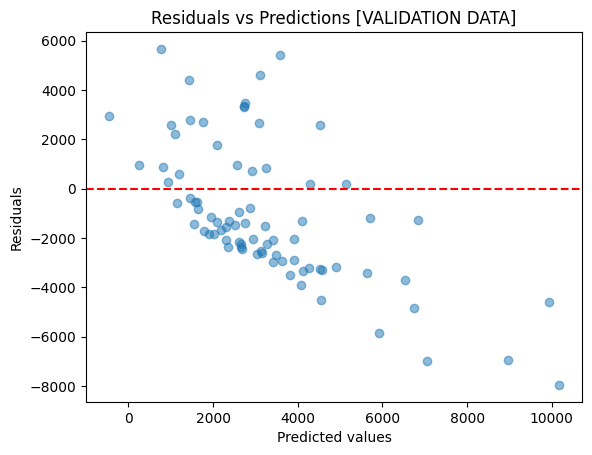

In [101]:
y_val = test[target]
y_val_pred = test['expected_demand']

resid_val = y_val - y_val_pred
import matplotlib.pyplot as plt

plt.scatter(y_val_pred, resid_val, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions [VALIDATION DATA]")
plt.show()

In [102]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import numpy as np
print("VALIDATION Heteroscedasticity TEST")
exog = sm.add_constant(y_val_pred)  
bp_test = het_breuschpagan(resid_val, exog)
print("Breusch–Pagan p-value:", bp_test[1])

white_test = het_white(resid_val, exog)
print("White test p-value:", white_test[1])

VALIDATION Heteroscedasticity TEST
Breusch–Pagan p-value: 2.3274180277771172e-08
White test p-value: 2.5708213838950355e-09


In [104]:
mask = y_val != 0
predictions = pd.DataFrame({
    # "item": test['item'],
    "date": test['date'],
    "y_val": y_val,
    "y_pred": y_val_pred,
    "actual_resid": resid_val,
})
predictions.to_csv("product_demand.csv", index=False)
predictions

,date,y_val,y_pred,actual_resid
391,2025-03-03,1006,3265.799688,-2259.799688
392,2025-03-04,1343,3406.583792,-2063.583792
393,2025-03-05,204,2022.419667,-1818.419667
394,2025-03-06,682,3630.744414,-2948.744414
395,2025-03-07,794,3480.577787,-2686.577787
...,...,...,...,...
465,2025-06-24,5758,3078.463160,2679.536840
466,2025-06-25,738,2300.684168,-1562.684168
467,2025-06-26,1888,3907.976632,-2019.976632
468,2025-06-27,1273,4579.582202,-3306.582202


In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

num_features = ['price', "day", "month", "year", "dayofweek", "dayofyear"] + lag_feats

train , test = split_train_test(df, split_date)
target = "qty_sold"
item_encoder = LabelEncoder()

train["item_label"] = item_encoder.fit_transform(train["item"])
# X_train, y_train = target_feature_split(train, features, target)
# X_val, y_val = target_feature_split(test, features, target)

label_features = ['item_label']
scaler = MinMaxScaler(feature_range=(0, 1))
train['price'] = scaler.fit_transform(train[['price']])
test['price'] = scaler.transform(test[['price']])
test['item_label'] = test['item'].map(
    lambda x: item_encoder.transform([x])[0] if x in item_encoder.classes_ else -1
)


In [59]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

/tmp/ipykernel_490757/2998219412.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)
/tmp/ipykernel_490757/2998219412.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)


In [61]:
seq_length = 10

def create_sequences(df, seq_length):
    X_num, X_item, y = [], [], []
    print(f"Range loop:{len(df) - seq_length} ")
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length]
        X_num.append(seq[num_features].values)
        X_item.append(seq[label_features].values)
        y.append(df.iloc[i+seq_length][target])
    return np.array(X_num), np.array(X_item), np.array(y)

X_train_num, X_train_item,  y_train = create_sequences(train, seq_length)
X_test_num, X_test_item, y_test = create_sequences(test, seq_length)
print("seq ready")

Range loop:716164 
Range loop:144121 
seq ready


In [79]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X_num, X_item, y):
        """
        X_num: numerical features (seq_len, num_features)
        X_item: item IDs (seq_len,)
        y: target values
        """
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_item = torch.tensor(X_item, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (samples,1)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_num[idx], self.X_item[idx], self.y[idx]
        
train_dataset = TimeSeriesDataset(X_train_num, X_train_item, y_train)
test_dataset  = TimeSeriesDataset(X_test_num, X_test_item, y_test)

train_loader = DataLoader(train_dataset, batch_size=124, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=124, shuffle=False)

import torch.nn as nn

class LSTMWithEmbeddings(nn.Module):
    def __init__(self, num_item, embedding_dim=8, hidden_size=64, num_features=6):
        super().__init__()
        self.item_emb = nn.Embedding(num_item, embedding_dim)
        self.lstm = nn.LSTM(input_size=num_features + embedding_dim,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x_num, x_item):
        x_item = x_item.squeeze(-1)
        emb_item = self.item_emb(x_item)
        x = torch.cat([x_num, emb_item], dim=2)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMWithEmbeddings(
    num_item=len(item_encoder.classes_),
    embedding_dim=8,
    hidden_size=64,
    num_features=X_train_num.shape[2]
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_num_batch, X_item_batch, y_batch in train_loader:
        X_num_batch = X_num_batch.to(device)
        X_item_batch = X_item_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        output = model(X_num_batch, X_item_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batches_done+=1
        
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")





Epoch 5, Loss: 379.6998
Epoch 10, Loss: 379.7015
Epoch 15, Loss: 379.7026
Epoch 20, Loss: 379.7026
Epoch 25, Loss: 379.7026
Epoch 30, Loss: 379.7026


In [82]:
from sklearn.metrics import root_mean_squared_error
import numpy as np

model.eval()  
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_num_batch, X_item_batch, y_batch in test_loader:
        X_num_batch = X_num_batch.to(device)
        X_item_batch = X_item_batch.to(device)
        y_batch = y_batch.to(device)
        
        output = model(X_num_batch, X_item_batch)
        
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(output.cpu().numpy())
        
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

rmse = root_mean_squared_error(y_true, y_pred)
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 16.0365
